# Visão Computacional - Trabalho Final
#### FIAP 2023
Trabalho final de Visão Computacional.
###### enunciado:
O grupo deve desenvolver uma automação para reconhecimento de face em um ambiente colaborativo para substituição do uso de cartões RFID para acessos em áreas restritas. O trabalho deverá:
- Classificar o rosto da colaborador com as possíveis classes:
        - Mecânico
        - Diretoria
        - Visitante
Além dessas classes é preciso informar:
       - Nome da pessoa 
       - Data de cadastro

Diferenciais para esse trabalho:

       - Criação de uma interface gráfica
       - Uso de banco de dados para registros
       - API paras consultas dos dados
       
O grupo pode usar qualquer tecnologia disponível para essa solução.

      - Visão computacional clássica
      - Deep Learning
      - API de ferramentas em nuvem (Azure, AWS, CGP e etc)

Para este trabalho usaremos o dataset __LFW - People (Face Recognition)__, obtido no __Kaggle__:
https://www.kaggle.com/datasets/atulanandjha/lfwpeople/

In [1]:
# imports iniciais
import os
import pandas as pd
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import json
import datetime
import shutil

#### Parte 1 - Criando database

Por não termos encontrado datasets de profissões, vamos gerar um modelo que define quem é a pessoa na foto, para então bater em uma base de dados CSV/Pandas e descobrir a profissão 'mockada'.

In [2]:
# caminho das imagens
dataset_path = 'lfw_funneled'

In [3]:
#construindo base de dados
person_df = [] #matriz para gerar dataframe
for person in  os.listdir(os.path.join(os.getcwd(), dataset_path)):
    try:
        cnt = len(os.listdir(os.path.join(os.getcwd(), dataset_path, person)))
        person_df.append([person, cnt])
    except:
        pass
person_df = pd.DataFrame(person_df)
person_df.columns = ['name','cnt_img']
person_df = (person_df[person_df['cnt_img']>=15]) #selecionando pessoas com 15 imagens ou mais
jobs = ['Mecânico', 'Diretoria', 'Visitante']
randJobs = [jobs[random.randint(0, 2)] \
            for person in range(person_df.shape[0])] #atribuindo trabalhos aleatoriamente
person_df.insert(2,'Job',randJobs)
randDates = [datetime.date(random.randint(2000,2023), random.randint(1,12), random.randint(1,28))\
           for person in range(person_df.shape[0])]
person_df.insert(3,'Date',randDates)

person_df.reset_index(drop=True)
person_df.to_csv('person_df.csv')

In [75]:
person_df

,Unnamed: 0,name,cnt_img,Job,Date
0,17,Abdullah_Gul,19,Mecânico,2006-12-22
1,121,Alejandro_Toledo,39,Visitante,2019-04-14
2,204,Alvaro_Uribe,35,Mecânico,2004-08-28
3,223,Amelie_Mauresmo,21,Visitante,2014-01-10
4,272,Andre_Agassi,36,Mecânico,2022-05-22
...,...,...,...,...,...
91,5480,Trent_Lott,16,Visitante,2005-07-19
92,5536,Venus_Williams,17,Visitante,2000-08-02
93,5541,Vicente_Fox,32,Mecânico,2020-10-09
94,5570,Vladimir_Putin,49,Diretoria,2004-10-01


In [4]:
## lendo arquivo
person_df = pd.read_csv('person_df.csv')
person_df['Job'].value_counts()

Mecânico     33
Visitante    32
Diretoria    31
Name: Job, dtype: int64

#### Parte 2 - Tratando imagens selecionadas
Como no início do trabalho definimos apenas algumas classes, vamos agora transformar todas as imagens das classes selecionadas (para enquadrar melhor o rosto em cada uma), para então separar em treino e teste

In [39]:
# extração de face
cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
def extract_transform_face(img):
    imagem = cv2.imread(img)
    face = cascade.detectMultiScale(imagem, 1.2, 5)
    for (x, y, w, h) in face:
        transformed_face = imagem[y:y+h, x:x+w]
        transformed_face = cv2.resize(transformed_face, (224,224), interpolation=cv2.INTER_LANCZOS4)

        return transformed_face
    
#plt.imshow(extract_transform_face(get_random_img()), cmap='gray')

In [235]:
#copiando arquivos de imagens das pessoas selecionadas
selected_dataset_path = 'selected_persons'
try:
    os.mkdir(selected_dataset_path)
except:
    pass
for person in person_df['name']:
    try:
        os.mkdir(os.path.join(selected_dataset_path, person))
        for file in os.listdir(os.path.join(dataset_path, person)):
            print (file)
            cv2.imwrite(os.path.join(selected_dataset_path, person, file), 
                        extract_transform_face(os.path.join(dataset_path, person, file)))
    except:
        pass

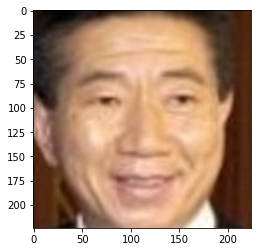

In [41]:
#demonstrando imagens aleatórias das pessoas selecionadas
def get_random_img():
    randperson_name = os.listdir(os.path.join(os.getcwd(), select_dataset_path))[random.randint(0, len(os.listdir(os.path.join(os.getcwd(), select_dataset_path)))-1)]
    randperson_photo = os.listdir(os.path.join(os.getcwd(), select_dataset_path, randperson_name))[random.randint(0, len(os.listdir(os.path.join(os.getcwd(), select_dataset_path, randperson_name)))-1)]
    randperson_photo_path = os.path.join(os.getcwd(), select_dataset_path, randperson_name, randperson_photo)
    return randperson_photo_path
get_random_img()

plt.imshow(cv2.cvtColor(cv2.imread(get_random_img()),cv2.COLOR_BGR2RGB))


#### Parte 3 - Modelo
Usaremos o VGG19 com Transfer Learning

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import Model, layers
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

In [43]:
#tentando carregar modelo, ou reconstruindo
try:
    model = load_model('modelos/vgg19_lfwpeople.h5')
except:
    conv_base = VGG19(include_top=False)
    for layer in conv_base.layers:
        layer.trainable = False
    x = layers.GlobalAveragePooling2D()(conv_base.output)
    x = layers.Dense(128, activation='relu')(x) 
    predictions = layers.Dense(96, activation='softmax')(x)
    model = Model(conv_base.input, predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [44]:
# instanciando gerador de imagens
imggen = ImageDataGenerator(
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3,
    preprocessing_function=preprocess_input)

X_train = imggen.flow_from_directory(select_dataset_path,
                           batch_size=32,
                           class_mode="categorical",
                           color_mode='rgb',
                           target_size=(224,224),
                           subset='training')
X_test = imggen.flow_from_directory(select_dataset_path,
                           batch_size=32,
                           class_mode="categorical",
                           color_mode='rgb',
                           target_size=(224,224),
                           subset='validation')

Found 1663 images belonging to 96 classes.
Found 657 images belonging to 96 classes.


In [97]:
#realizando fit e save no modelo
model.fit(X_train, epochs = 30, validation_data = X_test)
model.save('modelos/vgg19_lfwpeople.h5')

Epoch 1/30
52/52 [==============================] - 373s 7s/step - loss: 0.3680 - accuracy: 0.9068 - val_loss: 2.4802 - val_accuracy: 0.4612
Epoch 2/30
52/52 [==============================] - 409s 8s/step - loss: 0.3613 - accuracy: 0.9146 - val_loss: 2.5187 - val_accuracy: 0.4962
Epoch 3/30
52/52 [==============================] - 413s 8s/step - loss: 0.3496 - accuracy: 0.9128 - val_loss: 2.4831 - val_accuracy: 0.4779
Epoch 4/30
52/52 [==============================] - 389s 8s/step - loss: 0.3184 - accuracy: 0.9278 - val_loss: 2.5544 - val_accuracy: 0.5114
Epoch 5/30
52/52 [==============================] - 385s 7s/step - loss: 0.2955 - accuracy: 0.9194 - val_loss: 2.5489 - val_accuracy: 0.4825
Epoch 6/30
52/52 [==============================] - 387s 7s/step - loss: 0.2961 - accuracy: 0.9296 - val_loss: 2.5195 - val_accuracy: 0.4992
Epoch 7/30
52/52 [==============================] - 383s 7s/step - loss: 0.2782 - accuracy: 0.9333 - val_loss: 2.5825 - val_accuracy: 0.4901
Epoch 8/30
52

O fit do modelo rodou por 60 épocas, primeiramente em 3 operações cada com 10 épocas, salvando o modelo a cada operação, depois uma com 30 épocas, mostrada acima.

#### Parte 4 - Demostrando resultados
Demonstrando nome, como também profissão e data mockadas em imagem (treino e/ou teste) original aleatória

1/1 [==============================] - 0s 159ms/step
Nome: George W Bush
Profissão Mockada: Mecânico
Data Mockada: 2010-09-17


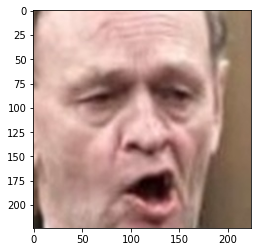

In [236]:
person = get_random_img()
plt.imshow(cv2.cvtColor(cv2.imread(person),cv2.COLOR_BGR2RGB))

predicao = model.predict(np.array([cv2.imread(person)])).argmax(axis=-1)

print ('Nome:', person_df.at[person_df.index[predicao[0]],'name'].replace('_', ' '))
print ('Profissão Mockada:', person_df.at[person_df.index[predicao[0]],'Job'])
print ('Data Mockada:', person_df.at[person_df.index[predicao[0]],'Date'])

###### FIM